# Task 5 - Learning crowd dynamics

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA

from scipy.stats import randint
from sklearn.utils.fixes import loguniform

from helpers.data import load_mi_data
from helpers.plot import plot_pandas_dataset, plot_3d_plot
from helpers.utils import (
    create_delay_embedding,
    compute_arc_length,
    integrate_over_periodic_velocity,
    reset_to_0_every_n,
)
from helpers.models import RBFRegression, get_best_model


### Constants

In [2]:
# DATA
SKIP_FIRST = 1000
TIMESTEPS_DAY = 2000

# DELAY EMBEDDING
NUM_WINDOWS = 13000
NUM_DELAYS = 350
COLUMNS_TO_CONSIDER = [0, 1, 2]

# STATE REPRESENTATION
STATE_DIM = 3


### Random seed

In [3]:
np.random.seed(47)

## 1 - Load and plot the data

The dataset `MI_timestep.txt` contains pedestrian utilization data measured at 9 different local areas on the campus over the duration of 7 days.
One day is equal to 2000 timesteps. The first measurement area is located at the MI building.

### 1.1 Load the data skipping the first 1000 timesteps

In [4]:
df = load_mi_data("data/MI_timesteps.txt", skip_first=SKIP_FIRST)
df.shape


(14001, 9)

The shape of the data meets our expectations. Let's take a closer look at the values.

In [5]:
df


,areaDensityCounting-PID5,areaDensityCounting-PID6,areaDensityCounting-PID7,areaDensityCounting-PID8,areaDensityCounting-PID9,areaDensityCounting-PID10,areaDensityCounting-PID11,areaDensityCounting-PID12,areaDensityCounting-PID13
timeStep,,,,,,,,,
1001,0,2,97,7,0,0,5,1,43
1002,0,2,96,7,0,0,5,1,45
1003,0,2,95,6,0,0,5,0,46
1004,0,2,94,6,0,0,4,1,46
1005,0,2,92,6,0,0,5,0,46
...,...,...,...,...,...,...,...,...,...
14997,0,10,95,4,0,0,2,1,39
14998,0,10,94,3,0,0,3,1,39
14999,0,10,93,3,0,1,2,1,40


Let's reset the index to start at 0 and rename the first column since we know it is about the MI building

In [6]:
df = df.reset_index(drop=True)
df.columns.values[0] = "MI_Building"


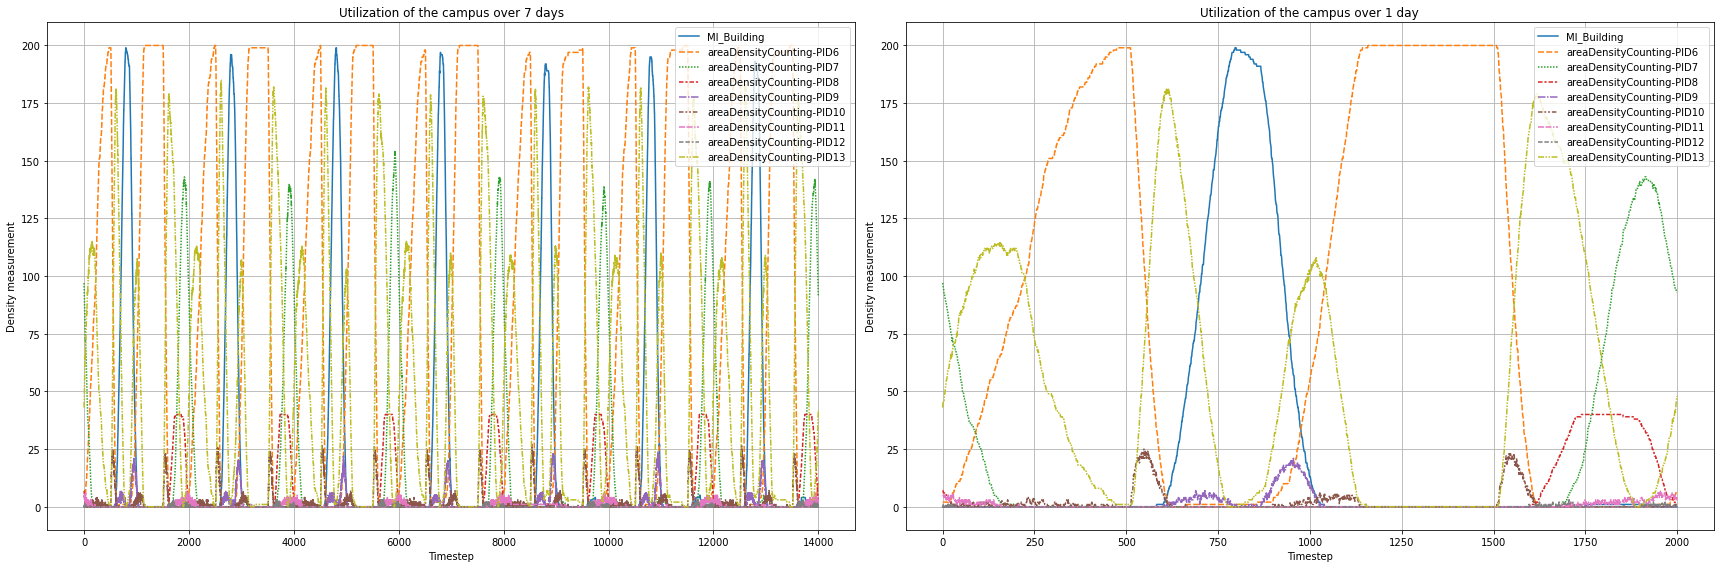

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))
axs[0] = plot_pandas_dataset(
    df,
    x_label="Timestep",
    y_label="Density measurement",
    title="Utilization of the campus over 7 days",
    ax=axs[0],
    legend_loc="upper right",
)
axs[0].grid(True)
axs[1] = plot_pandas_dataset(
    df.iloc[:TIMESTEPS_DAY, :],
    x_label="Timestep",
    y_label="Density measurement",
    title="Utilization of the campus over 1 day",
    ax=axs[1],
    legend_loc="upper right",
)
axs[1].grid(True)
fig.tight_layout()
fig.savefig("plots/5_dataset.pdf", bbox_inches="tight")


## 2 - Create a reasonable state space for the system

According to Takens, we need 2d + 1 dimensions in our state space in order to capture the full state. Here the dimension d of our manifold is 1 since it is periodic in time and has no further parametric dependencies (like different properties of different pedestrians). Therefore, 3 dimensions are enough for our state space. One can think of it like a 9-dimensional circle that is periodic every day.

### 2.1 Create delay embedding with 350 delays each

In [8]:
delay_embedding = create_delay_embedding(
    df, num_windows=NUM_WINDOWS, num_delays=NUM_DELAYS, column_index_to_look_at=COLUMNS_TO_CONSIDER
)
delay_embedding.shape


(13000, 1053)

### 2.2 Convert delay embeddings into 3 - dimensional subspace

In [9]:
pca = PCA(n_components=STATE_DIM)
state_space = pca.fit_transform(delay_embedding)
state_space.shape


(13000, 3)

## 3. Observe the newly created state space

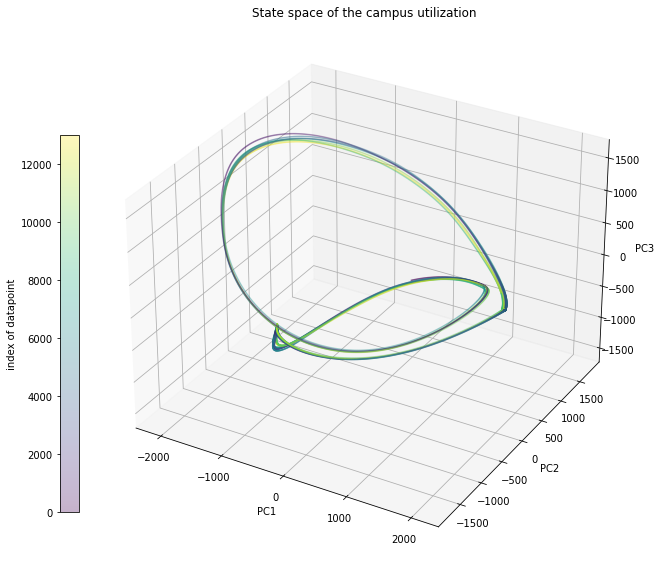

In [10]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection="3d")
plot_3d_plot(
    state_space,
    xlabel="PC1",
    ylabel="PC2",
    zlabel="PC3",
    title="State space of the campus utilization",
    ax=ax,
    fig=fig,
    title_colorbar="index of datapoint",
    c=np.arange(state_space.shape[0]),
    s=0.5,
    alpha=0.3,
)
fig.tight_layout()
fig.savefig("plots/5_state_space.pdf", bbox_inches="tight")


One can the the periodic nature of the state space, as the original state space is also periodic.

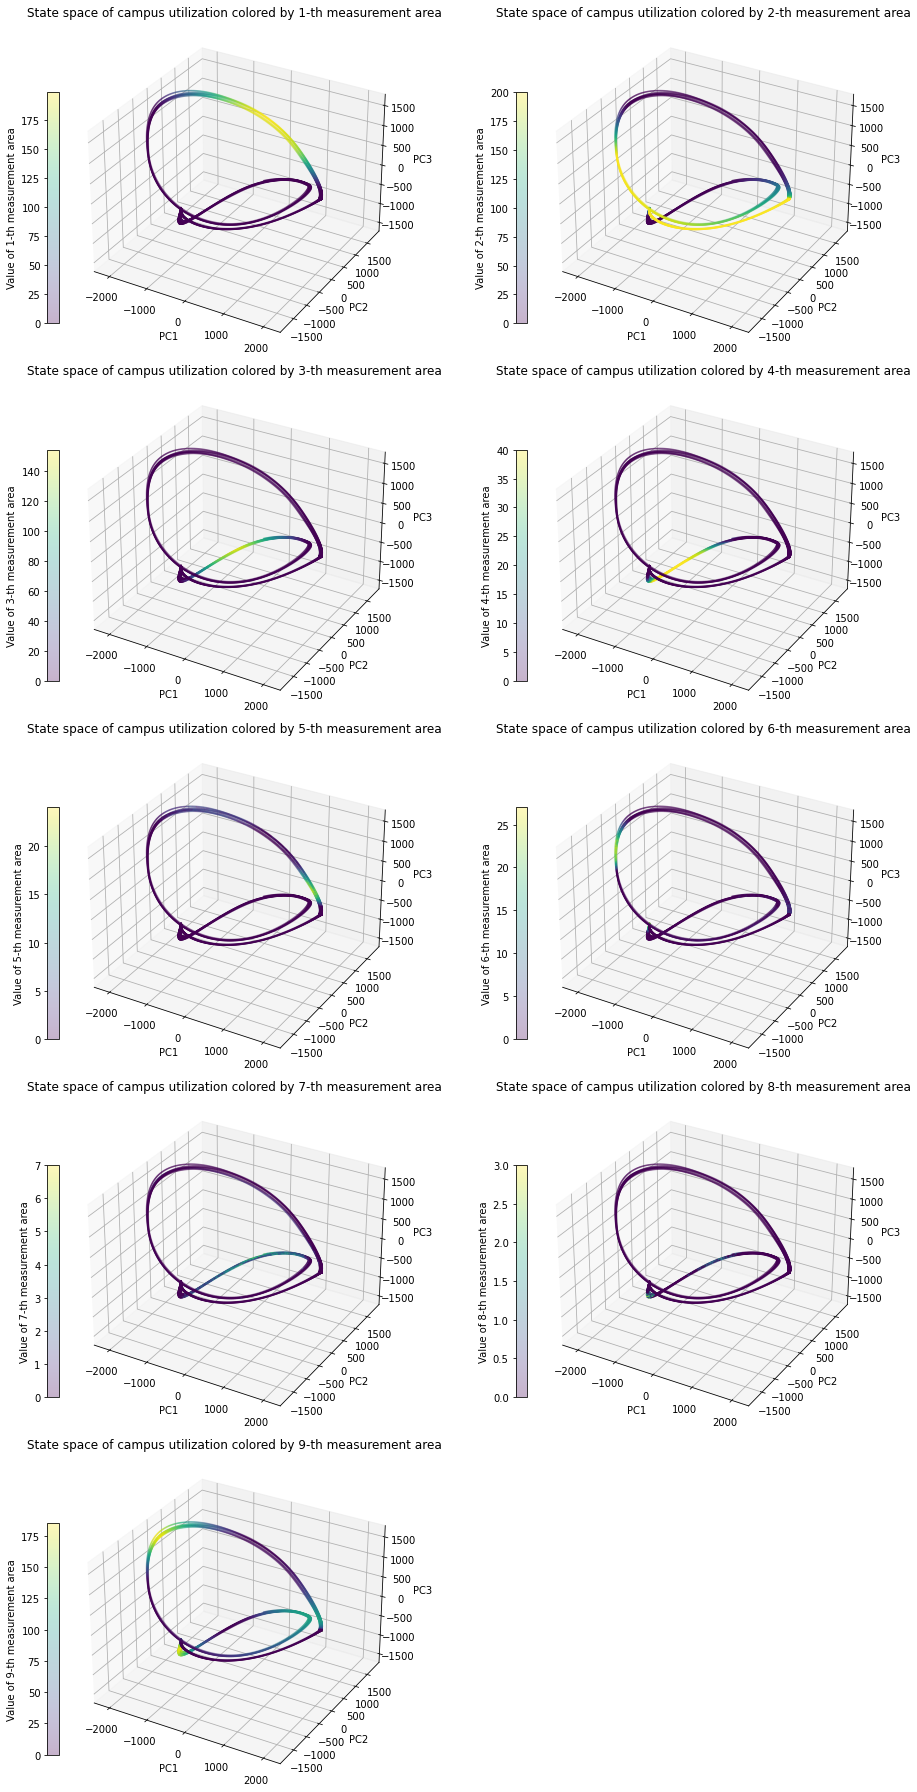

In [11]:
NUM_PLOTS = df.shape[1]
NUM_COLS = 2
NUM_ROWS = NUM_PLOTS // NUM_COLS + 1

fig = plt.figure(figsize=(NUM_COLS * 7, NUM_ROWS * 5))

for measurement_area in range(0, NUM_PLOTS):
    ax = fig.add_subplot(NUM_ROWS, NUM_COLS, measurement_area + 1, projection="3d")
    ax.set_aspect("auto")
    ax = plot_3d_plot(
        state_space,
        xlabel="PC1",
        ylabel="PC2",
        zlabel="PC3",
        title=f"State space of campus utilization colored by {measurement_area + 1}-th measurement area",
        ax=ax,
        fig=fig,
        title_colorbar=f"Value of {measurement_area+1}-th measurement area",
        c=df.iloc[: state_space.shape[0], measurement_area],
        s=0.5,
        alpha=0.3,
    )

fig.tight_layout()
fig.savefig("plots/5_state_space_colored_by_measurement_area.pdf", bbox_inches="tight")


## 4 - Compute dynamics of state space

### 4.1 Compute the arclength

In [12]:
state_space_arc_length = compute_arc_length(state_space)


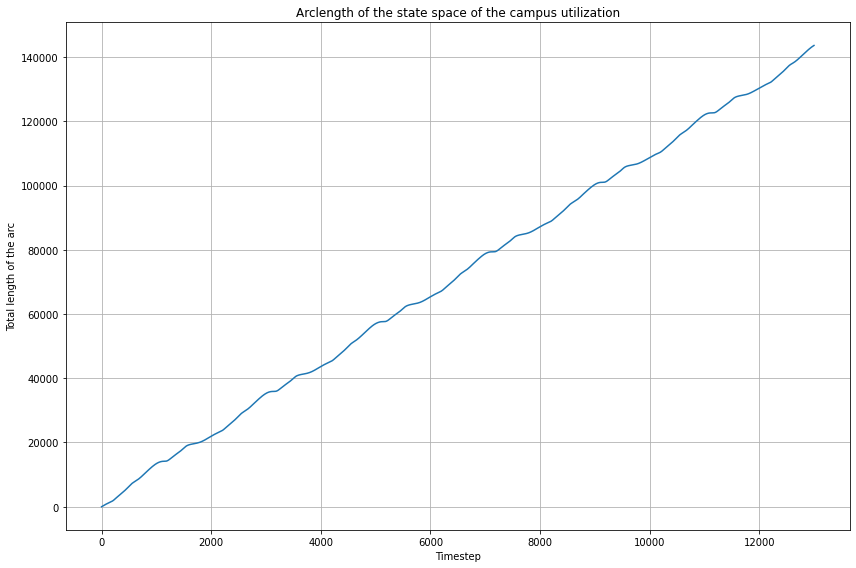

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_length)
ax.set_xlabel("Timestep")
ax.set_ylabel("Total length of the arc")
ax.set_title("Arclength of the state space of the campus utilization")
ax.grid(True)
fig.tight_layout()
fig.savefig("plots/5_state_space_arc_length.pdf", bbox_inches="tight")


### 4.2 Estimate the change in arclength over time = velocity

In [14]:
state_space_arc_velocity = np.gradient(state_space_arc_length)


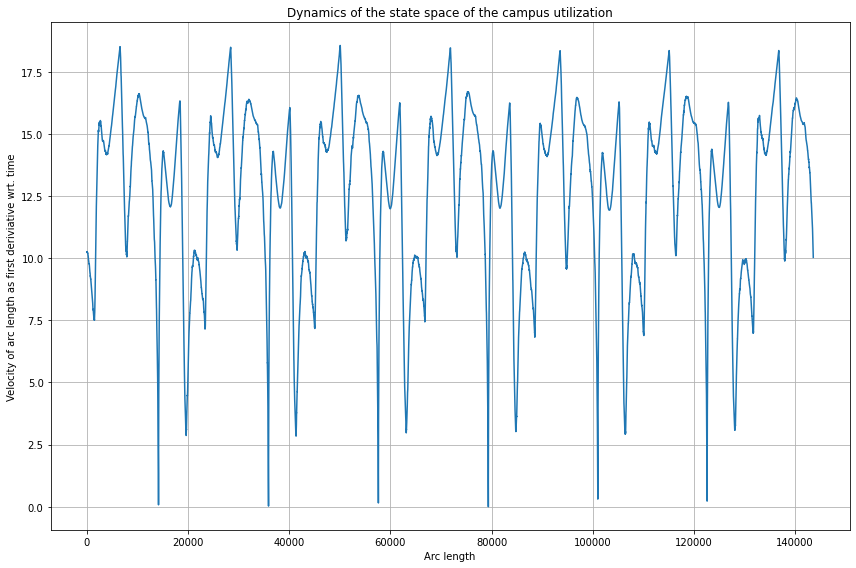

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_length, state_space_arc_velocity)
ax.set_xlabel("Arc length")
ax.set_ylabel("Velocity of arc length as first deriviative wrt. time")
ax.set_title("Dynamics of the state space of the campus utilization")
ax.grid(True)
fig.tight_layout()
fig.savefig("plots/5_state_space_dynamics_over_arc_length.pdf", bbox_inches="tight")


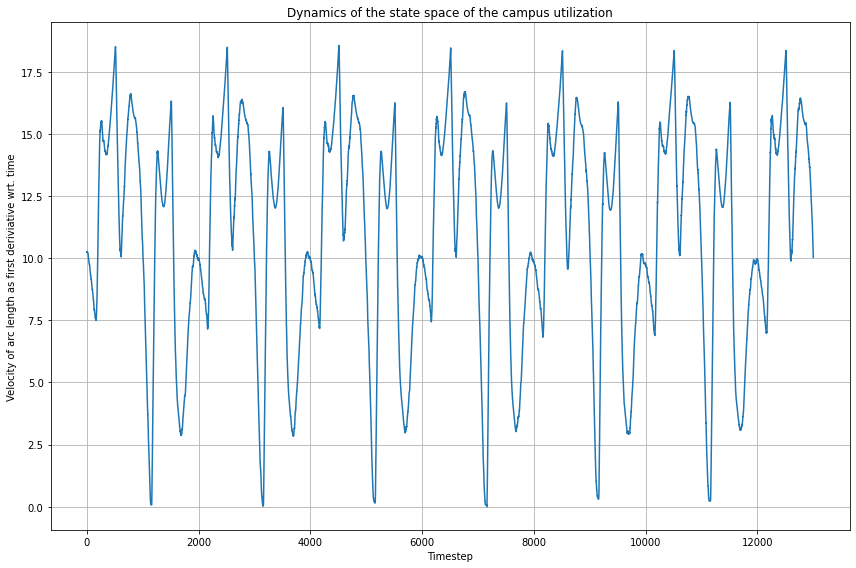

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_velocity)
ax.set_xlabel("Timestep")
ax.set_ylabel("Velocity of arc length as first deriviative wrt. time")
ax.set_title("Dynamics of the state space of the campus utilization")
ax.grid(True)
fig.tight_layout()
fig.savefig("plots/5_state_space_dynamics_over_timestep.pdf", bbox_inches="tight")


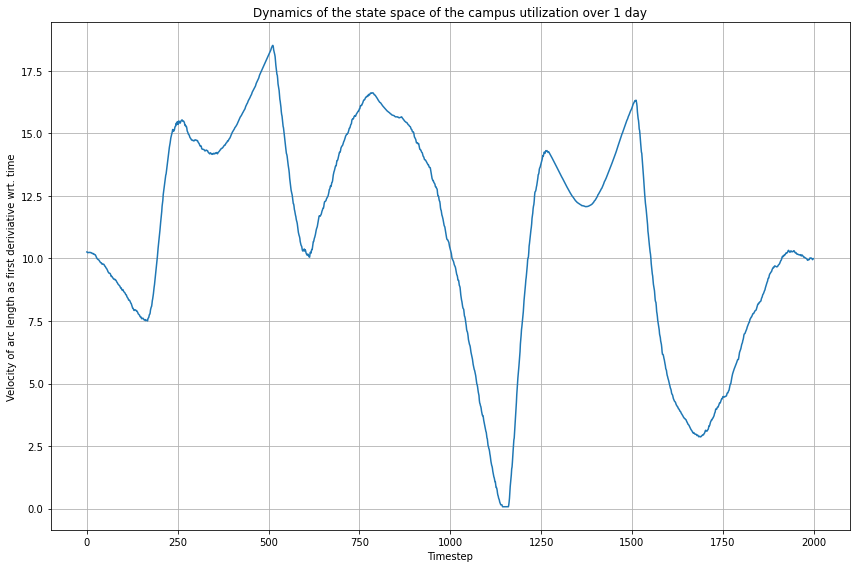

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_velocity[:2000])
ax.set_xlabel("Timestep")
ax.set_ylabel("Velocity of arc length as first deriviative wrt. time")
ax.set_title("Dynamics of the state space of the campus utilization over 1 day")
ax.grid(True)
fig.tight_layout()
fig.savefig("plots/5_state_space_dynamics_over_timestep_1day.pdf", bbox_inches="tight")


## 5. Predict arc length for the next 14 days

In [18]:
arc_length_14_days = integrate_over_periodic_velocity(
    velocities=state_space_arc_velocity[:2000], timesteps_to_integrate=14 * 2000
)
arc_length_14_days.shape


(28000,)

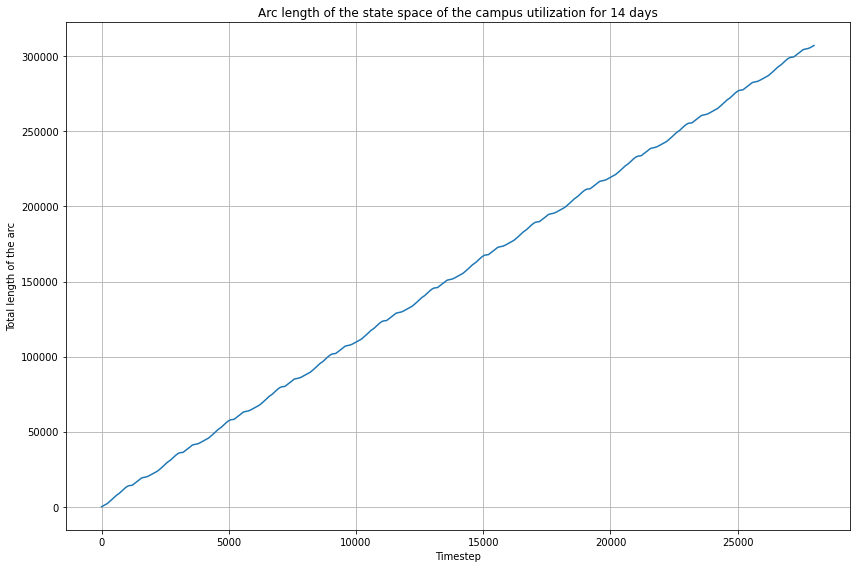

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(arc_length_14_days)
ax.set_xlabel("Timestep")
ax.set_ylabel("Total length of the arc")
ax.set_title("Arc length of the state space of the campus utilization for 14 days")
ax.grid(True)
fig.tight_layout()
fig.savefig("plots/5_state_space_arc_length_14_days.pdf", bbox_inches="tight")


## 6. Fit mapping between arclength space and utilization of first measurement zone

We want to find a mapping $f(x): \mathbf{R} \rightarrow \mathbf{R}$ that maps from the arc length of the state space to the utilization value of the MI building.

### 6.1 Inspect the relationship

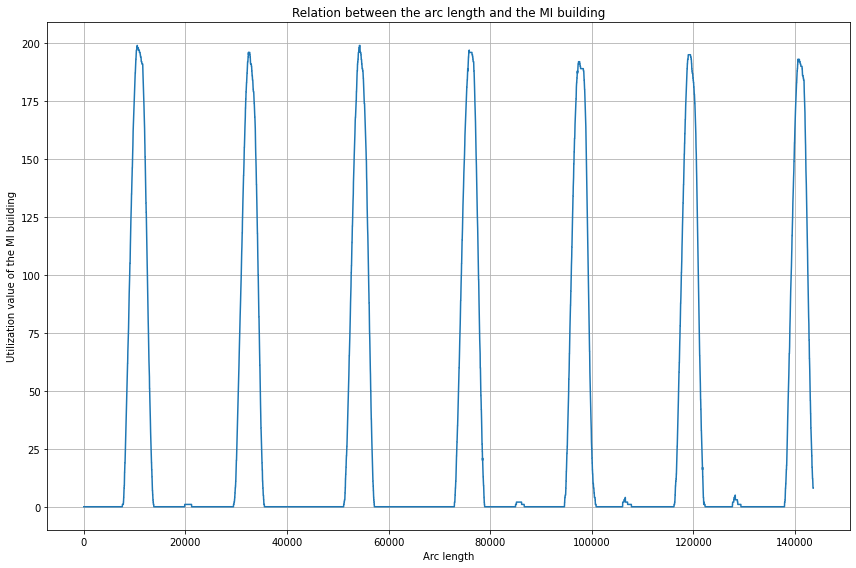

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(state_space_arc_length, df.iloc[: state_space_arc_length.shape[0], 0])
ax.set_xlabel("Arc length")
ax.set_ylabel("Utilization value of the MI building")
ax.set_title("Relation between the arc length and the MI building")
ax.grid(True)
fig.tight_layout()
fig.savefig("plots/5_state_space_relation_arc_length_mi_building.pdf", bbox_inches="tight")

### 6.2 Use RBF Regression to approximate the relation

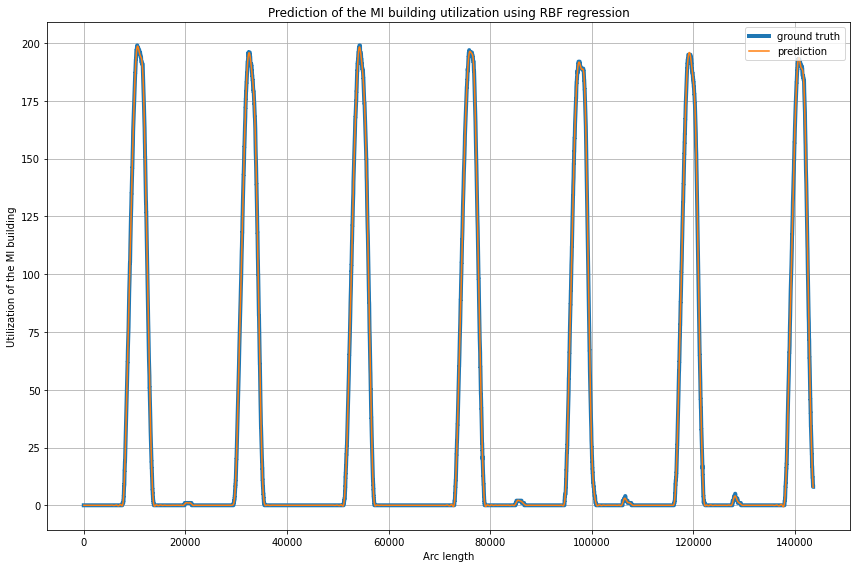

In [54]:
rbf = RBFRegression(eps=TIMESTEPS_DAY / 3, L=1000, lamb=1e-3)
X = state_space_arc_length
y = df.iloc[:state_space_arc_length.shape[0], 0]
rbf.fit(X, y)
y_pred = rbf.predict(X)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X, y, label="ground truth", linewidth=4)
ax.plot(X, y_pred, label="prediction")
ax.legend(loc="upper right")
ax.set_title("Prediction of the MI building utilization using RBF regression")
ax.set_xlabel("Arc length")
ax.set_ylabel("Utilization of the MI building")
ax.grid(True)
fig.tight_layout()
fig.savefig("plots/5_state_space_prediction_mi_building.pdf", bbox_inches="tight")

## 7. Use the learnt mapping to predict the utilization for the next 14 days

### 7.1 By applying the mapping to the new arc length vector over 14 days

/tmp/ipykernel_5544/1222658763.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(df.iloc[:, 0], label="ground truth", lineWidth=4)


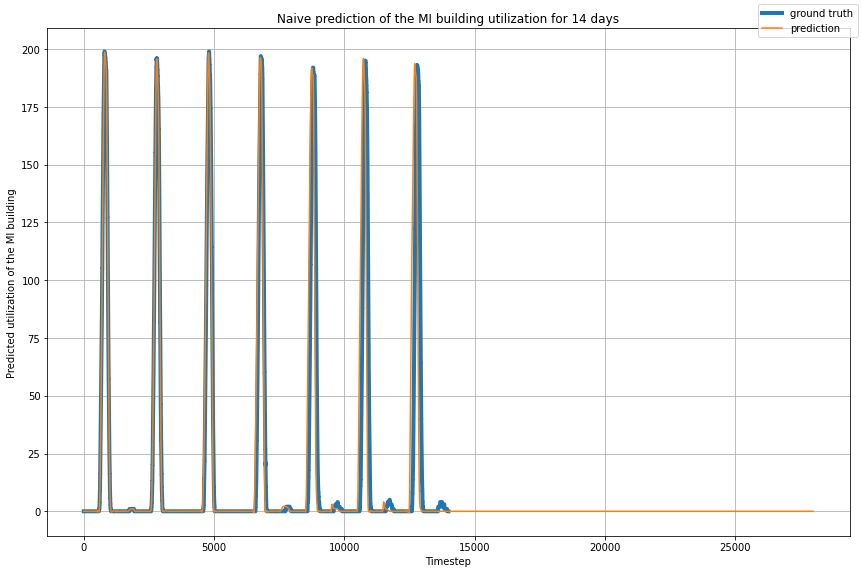

In [56]:
pred = rbf.predict(arc_length_14_days)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df.iloc[:, 0], label="ground truth", lineWidth=4)
ax.plot(pred, label="prediction")
ax.set_xlabel("Timestep")
ax.set_ylabel("Predicted utilization of the MI building")
ax.set_title("Naive prediction of the MI building utilization for 14 days")
ax.grid(True)
fig.legend(loc="upper right")
fig.tight_layout()
fig.savefig("plots/5_state_space_naive_prediction_mi_building_14d.pdf", bbox_inches="tight")


Since the new arc length over 14 days as an input to the learnt mapping reaches values greater than the range of values during training, the RBF needs to extrapolate.
However due to the L-RBF functions chosen at random only within the input range during training, the extrapolation cannot work.
What one could do is to choose the RBF function centers also outside the training data. Here we choose a different approach as explained in the following subchapter.

### 7.2 By first adjusting the arc length vector of 14 days to match the input range during training

Let's make sure that we only need to interpolate by resetting our new 14 days arc length to zero every day.
This assumption is okay to make since we assume that the data is periodic every day anyway.

In [23]:
arc_length_14_days_adjusted = reset_to_0_every_n(X=arc_length_14_days, n=TIMESTEPS_DAY)

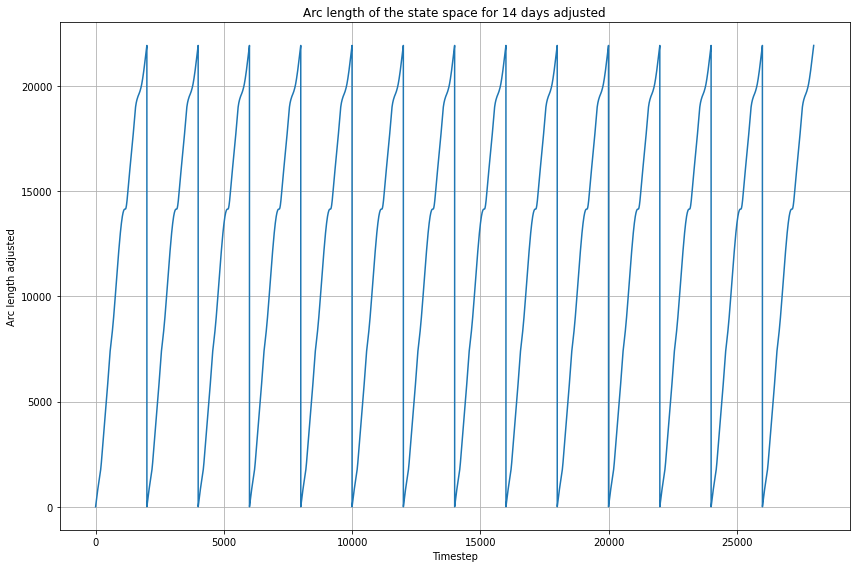

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(arc_length_14_days_adjusted)
ax.set_xlabel("Timestep")
ax.set_ylabel("Arc length adjusted")
ax.set_title("Arc length of the state space for 14 days adjusted")
ax.grid(True)
fig.tight_layout()
fig.savefig("plots/5_state_space_arc_length_14_days_adjusted.pdf", bbox_inches="tight")


/tmp/ipykernel_5544/734582773.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.plot(df.iloc[:, 0], label="ground truth", lineWidth=4)


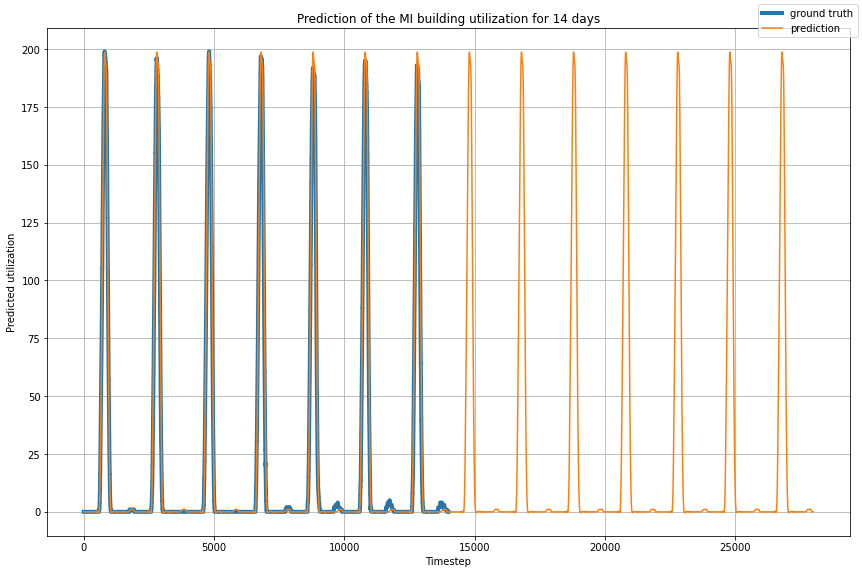

In [58]:
pred = rbf.predict(arc_length_14_days_adjusted)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df.iloc[:, 0], label="ground truth", lineWidth=4)
ax.plot(pred, label="prediction")
ax.set_xlabel("Timestep")
ax.set_ylabel("Predicted utilization")
ax.set_title("Prediction of the MI building utilization for 14 days")
ax.grid(True)
fig.legend(loc="upper right")
fig.tight_layout()
fig.savefig("plots/5_state_space_prediction_mi_building_14d.pdf", bbox_inches="tight")


Obviously, the predictions are periodic as well, as the inputs is too. Nonetheless, we can see that the prediction approximates the past observations pretty well and manages to forecast the next 14 days.